<h1><center>SETI Breakthrough Listen - E.T. Signal Search</center></h1>
<h2><center>Find extraterrestrial signals in data from deep space</center></h2>

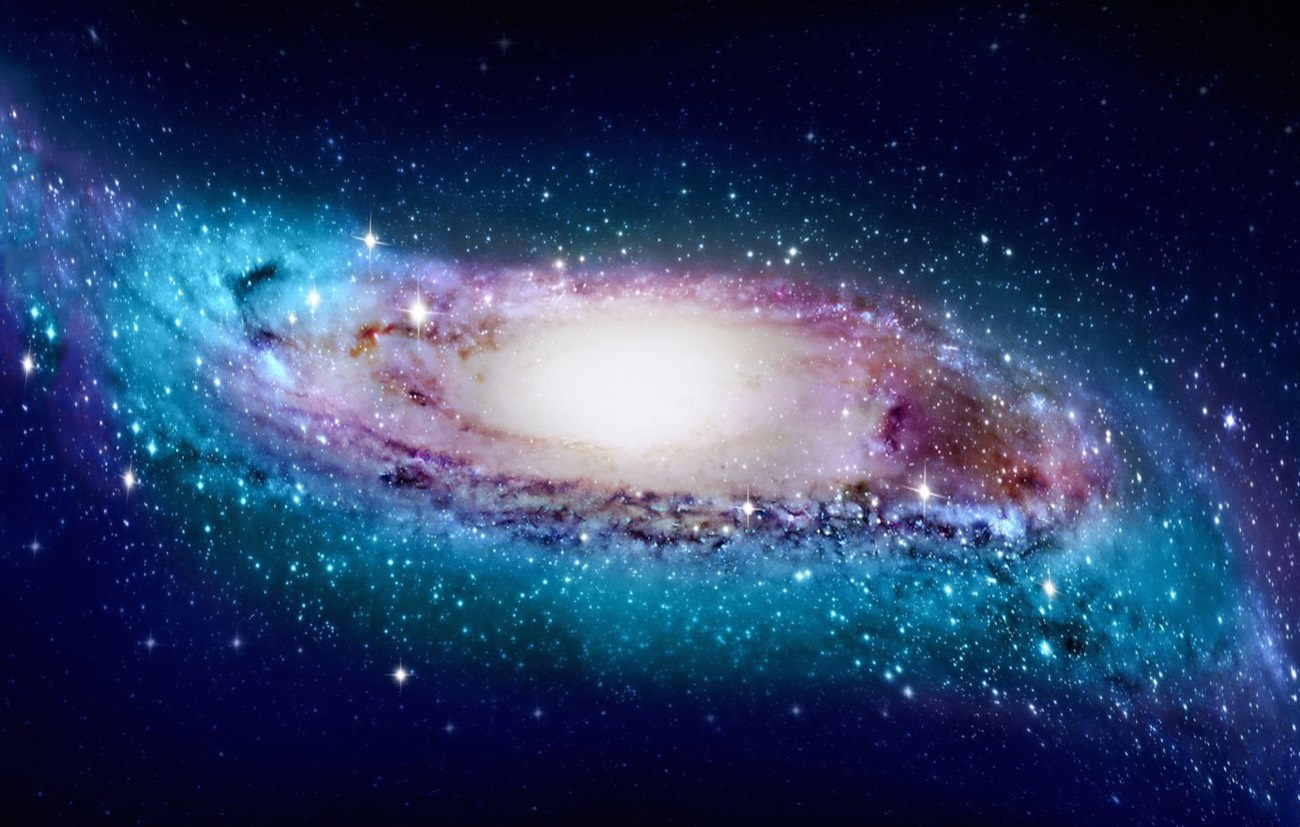

<h2><center>1. Competition Understanding</center></h2>

#### Introduction
<ul>
  <li>In this competition, we have to use our data science skills to help identify anomalous signals in scans of Breakthrough Listen targets. Because there are no confirmed examples of alien signals to use to train machine learning algorithms, the team included some simulated signals (that they call “needles”) in the haystack of data from the telescope.They have identified some of the hidden needles so that you can train your model to find more.</li>
 <li>The data consist of two-dimensional arrays, so there may be approaches from computer vision that are promising, as well as digital signal processing, anomaly detection, and more.</li>
 <li>The algorithm that’s successful at identifying the most needles will win a cash prize, but also has the potential to help answer one of the biggest questions in science.</li>
   

#### Goal
The main objective of the competition is to <b> accurately classify anomalous signals </b> in scans of Breakthrough Listen targets using machine learning-based models.

##### Let's have a look at the data now...
<h2><center>2. Exploratory Data Analysis</center></h2>


In [ ]:
# Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from colorama import Fore, Back, Style
r_ = Fore.WHITE
from plotly.offline import iplot
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


In [ ]:
# Train 
train_labels=pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
train_labels.head()

In [ ]:
cmap_plot = plt.get_cmap('jet_r')
ddt = train_labels.target.value_counts().to_frame()
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
sns.countplot(data = train_labels, x = 'target', orient = "v", palette = 'pastel', ax = ax)
plt.suptitle("Train target distribution")
plt.rcParams.update(plt.rcParamsDefault)

##### We can infer from the graph above that the data is imbalanced. We will keep this in mind while creating the model for this data.

In [ ]:
train_files = glob.glob("../input/seti-breakthrough-listen/train" + "/*/*.npy")
print("\t\t\t\t{}{}Number of train files: {}".format(r_, Back.BLACK, len(train_files)))

#### Now let's visualize the Train and Test Dataset

In [ ]:
def get_train_filename_by_id(_id: str) -> str:
    return f"../input/seti-breakthrough-listen/train/{_id[0]}/{_id}.npy"

def show_cadence(filename: str, label: int) -> None:
    fig, axes = plt.subplots(6, 1, figsize = (16, 10))
    ax = axes.ravel()
    arr = np.load(filename)
    for i in range(6):
        
        ax[i].imshow(arr[i].astype(float), interpolation='nearest', aspect='auto')
        ax[i].text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
        if i != 5:
            ax[i].set_xticks([])
            
    fig.text(0.5, -0.02, 'Frequency Range', ha='center', fontsize=18)
    fig.text(-0.02, 0.5, 'Seconds', va='center', rotation='vertical', fontsize=18)

    plt.suptitle(f"ID: {os.path.basename(filename)} TARGET: {label}", fontsize=18)
    fig.tight_layout()
    plt.show()

In [ ]:
positive_target=train_labels.query("target==1").sample().id.item()
negative_target=train_labels.query("target==0").sample().id.item()
show_cadence(get_train_filename_by_id(positive_target), 1)
show_cadence(get_train_filename_by_id(negative_target), 0)

In [ ]:
#Test
test_files = glob.glob('../input/seti-breakthrough-listen/test' + "/*/*.npy")
print("\t\t\t\t{}{}Number of test files: {}".format(r_, Back.BLACK, len(test_files)))

In [ ]:
show_cadence(np.random.choice(test_files, 1).item(), None)
show_cadence(np.random.choice(test_files, 1).item(), None)

##### Lets kickstart the modelling..
<h2><center>3. Model: EffiecientNet</center></h2>

In [ ]:
#Libraries
import os
import sys
sys.path=['../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',]+sys.path
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import torch
import torch.nn as nn
from efficientnet_pytorch import model as enet
import random
from sklearn.model_selection import StratifiedKFold


In [ ]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)
    

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

In [ ]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets): 
        self.image_paths = image_paths
        self.targets = targets

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)

        targets = self.targets[item]
                
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [ ]:
df_train=pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
df_train.head()

In [ ]:
df_train['img_path']=df_train['id'].apply(lambda x:f'../input/seti-breakthrough-listen/train/{x[0]}/{x}.npy')
df_train.head()

In [ ]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [ ]:
def train(data_loader, model, optimizer, device):
    
    model.train()
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        inputs = data["image"]
        targets = data['targets']
        
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        
def evaluate(data_loader, model, device):
    model.eval()
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets

In [ ]:
baseline_name = 'efficientnet-b1'
pretrained_model = {
    baseline_name: '../input/efficientnet-pytorch/efficientnet-b1-dbc7070a.pth'
}
models = []
device = "cuda"
epochs = 3
Batch_Size = 32
X = df_train.img_path.values
Y = df_train.target.values
skf = StratifiedKFold(n_splits=5)
fold = 0

for train_index, test_index in skf.split(X, Y):
    
    model = enetv2(baseline_name, out_dim=1)
    model.to(device)

    train_images, valid_images = X[train_index], X[test_index]
    train_targets, valid_targets = Y[train_index], Y[test_index]

    train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets)
    valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    for epoch in range(epochs):
        train(train_loader, model, optimizer, device=device)
        predictions, valid_targets = evaluate(valid_loader, model, device=device)
        roc_auc = metrics.roc_auc_score(valid_targets, predictions)
        print(f"Epoch={epoch}, Valid ROC AUC={roc_auc}")
        
    torch.save(model.state_dict(),baseline_name + '-' + str(fold) + '.pt')
    models.append(model)
    fold += 1

In [ ]:
submission=pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')
submission['img_path']=submission['id'].apply(lambda x:f'../input/seti-breakthrough-listen/test/{x[0]}/{x}.npy')

In [ ]:
test_dataset=ClassificationDataset(image_paths=submission.img_path.values, targets=submission.target.values)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=16,shuffle=False,num_workers=4)

In [ ]:
sig=torch.nn.Sigmoid()
outs=[]
for model in models:
    predictions,valid_targets=evaluate(test_loader, model, device=device)
    predictions=np.array(predictions)[:,0]
    out=sig(torch.from_numpy(predictions))
    out=out.detach().numpy()
    outs.append(out)
    

In [ ]:
pred=np.mean(np.array(outs),axis=0)

In [ ]:
submission.target=pred
submission.drop(['img_path'],axis=1,inplace=True)
submission.to_csv('submission.csv', index=False)


In [ ]:
submission.head()